# Package Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from scipy import stats
import plotly.graph_objs as go
import plotly.express as px
import networkx as nx
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
import math
import mpld3
from mpld3 import plugins
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
from collections import Counter
import itertools
import xgboost as xgb
from xgboost import plot_tree
%matplotlib inline


In [2]:

from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)

# DataFrame Imports

In [3]:
prototype_frame = pd.read_csv("./Data/prototype_frame.csv", low_memory=False, index_col=0)

prototype_frame

,advantage_mean,believability_mean,purchase_likelihood_mean,premiumness_mean,concept_id,one or multiple flavors_mapped_clean_One Flavour,one product or product mix_mapped_clean_One Product,ingredients mentioned in the flavor names_mapped_clean_Cheese,types of snack does it describe_mapped_clean_Puffs,types of snack does it describe_mapped_clean_Chips,textures described_mapped_clean_Crispy,textures described_mapped_clean_Crunchy,taste profile_mapped_clean_Cheesy,"when, where or why does it explicitly suggest using or having the snack_mapped_clean_Sharing",shapes mentioned_mapped_clean_Rings,one or multiple flavors_mapped_clean_Multiple Flavours,ingredients mentioned in the flavor names_mapped_clean_Fruit,ingredients mentioned in the flavor names_mapped_clean_Nuts,ingredients mentioned in the flavor names_mapped_clean_Chocolate,types of snack does it describe_mapped_clean_Potato,textures described_mapped_clean_Chewy,taste profile_mapped_clean_Sweet,taste profile_mapped_clean_Salty,"when, where or why does it explicitly suggest using or having the snack_mapped_clean_Grazing",shapes mentioned_mapped_clean_Clusters,multipack or single serving_mapped_clean_Multipack,one product or product mix_mapped_clean_Product Mix,ingredients mentioned in the flavor names_mapped_clean_Herbs and Spices,ingredients mentioned in the flavor names_mapped_clean_Sour Cream,ingredients mentioned in the flavor names_mapped_clean_Ranch,ingredients mentioned in the flavor names_mapped_clean_Tomatoes,types of snack does it describe_mapped_clean_Tortilla,taste profile_mapped_clean_Savory,taste profile_mapped_clean_Spicy,"when, where or why does it explicitly suggest using or having the snack_mapped_clean_At a party","when, where or why does it explicitly suggest using or having the snack_mapped_clean_Perfect for dipping",cuisines of origin_mapped_clean_Mexican,"when, where or why does it explicitly suggest using or having the snack_mapped_clean_Entertaining guests",shapes mentioned_mapped_clean_Bites,ingredients mentioned in the flavor names_mapped_clean_Beef,ingredients mentioned in the flavor names_mapped_clean_Jalapeno,types of snack does it describe_mapped_clean_Meat Based,types of snack does it describe_mapped_clean_Jerky,explicitly claimed health or lifestyle benefits_mapped_clean_High Protein,taste profile_mapped_clean_Yeasty,"when, where or why does it explicitly suggest using or having the snack_mapped_clean_Defeat hunger",ingredients mentioned in the flavor names_mapped_clean_Sweet Chili,ingredients mentioned in the flavor names_mapped_clean_Lime,preparation or cooking method_mapped_clean_Kettle Cooked,cuisines of origin_mapped_clean_Japanese,...,textures described_mapped_clean_Meaty,shapes mentioned_mapped_clean_Scoopable,types of snack does it describe_mapped_clean_Popped,shapes mentioned_mapped_clean_Ridged,calorie count specified_mapped_clean_Specified,explicitly claimed health or lifestyle benefits_mapped_clean_Low fat or Reduced fat,textures described_mapped_clean_Flaky,multipack or single serving_mapped_clean_Both (multi-serve bag and individual sized bag),ingredients mentioned in the flavor names_mapped_clean_Chicken,ingredients mentioned in the flavor names_mapped_clean_Sriracha,"when, where or why does it explicitly suggest using or having the snack_mapped_clean_Watching TV",cuisines of origin_mapped_clean_Korean,taste profile_mapped_clean_Bitter,"when, where or why does it explicitly suggest using or having the snack_mapped_clean_For breakfast, lunch or dinner",taste profile_mapped_clean_Seasoned,explicitly claimed health or lifestyle benefits_mapped_clean_Plant Based,explicitly claimed health or lifestyle benefits_mapped_clean_No added MSG,explicitly claimed health or lifestyle benefits_mapped_clean_No Added Sugar,explicitly claimed health or lifestyle benefits_mapped_clean_Reduced Sugar,explicitly claimed health or lifestyle benefits_mapped_clean_Gluten free,multipack or single serving_mapped_clean_Not specified,preparation or cooking m

In [4]:
# Create a list to store the combinations of tags
tag_combinationz = []

# Iterate through each row in the DataFrame
for index, row in prototype_frame.iterrows():
    # Find tags with a value of 1 in the current row
    tags_in_row = [col for col in prototype_frame.columns if row[col] == 1]
    
    # Sort the tags to ensure consistent combinations
    tags_in_row.sort()
    
    # Convert the list of tags to a tuple to make it hashable
    tag_combination = tuple(tags_in_row)
    
    # Add the tag combination to the list
    tag_combinationz.append(tag_combination)

# Count the frequency of each tag combination
tag_combination_counts = pd.Series(tag_combinationz).value_counts()

# Create a DataFrame to display the results
result_df = pd.DataFrame(tag_combination_counts.reset_index())
result_df.columns = ['Tag Combination', 'Count']

# Sort the tag combinations by count in descending order
result_df = result_df.sort_values(by='Count', ascending=False)

result_df.to_csv('Data/combinations.csv')


## Feature Importance Plot

### Creating New Features

#### Importing tag_combinations

In [5]:
# Create an empty dictionary to store tag combinations
tag_combinations = {}

# Specify the path to the 'tag_combinations.txt' file
file_path = 'tag_combinations.txt'

# Open the file in read mode
with open(file_path, 'r') as txt_file:
    # Iterate through each line in the file
    for line in txt_file:
        # Split the line into parts using the ': ' delimiter
        parts = line.strip().split(': ')
        
        # Extract the pair of tags and their count
        tag_pair = tuple(parts[0].split(', '))
        count = int(parts[1])
        
        # Add the tag pair and count to the dictionary
        tag_combinations[tag_pair] = count

# Now, 'tag_combinations' contains the data read from the file
print(tag_combinations)

{('one product or product mix_mapped_clean_One Product', 'types of snack does it describe_mapped_clean_Puffs'): 96, ('one product or product mix_mapped_clean_One Product', 'taste profile_mapped_clean_Cheesy'): 225, ('one product or product mix_mapped_clean_One Product', 'one or multiple flavors_mapped_clean_Multiple Flavours'): 569, ('one product or product mix_mapped_clean_One Product', 'taste profile_mapped_clean_Spicy'): 210, ('one product or product mix_mapped_clean_One Product', 'explicitly claimed health or lifestyle benefits_mapped_clean_High Protein'): 67, ('one product or product mix_mapped_clean_One Product', 'when', 'where or why does it explicitly suggest using or having the snack_mapped_clean_Defeat hunger'): 81, ('one product or product mix_mapped_clean_One Product', 'explicitly claimed health or lifestyle benefits_mapped_clean_Nutritious'): 83, ('one product or product mix_mapped_clean_One Product', 'when', 'where or why does it explicitly suggest using or having the sna

#### Finding The Top 1% Most Prevalent Combinations

In [38]:
# Sort the tag combinations dictionary by count in descending order
sorted_combinations = sorted(tag_combinations.items(), key=lambda x: x[1], reverse=True)

# Calculate the threshold for the top 1%
total_combinations = len(sorted_combinations)
top_1_percent_threshold = int(total_combinations * 0.01)

# Select the top 1% combinations with the highest counts
top_1_percent_combinations = sorted_combinations[:top_1_percent_threshold]

# Print the top 1% combinations
#for combination, count in top_10_percent_combinations:
 #   print(combination, count)

print(f"There are {len(top_1_percent_combinations)} combinations/features")
print(top_1_percent_combinations)

There are 49 combinations/features
[(('one product or product mix_mapped_clean_One Product', 'one or multiple flavors_mapped_clean_Multiple Flavours'), 569), (('one product or product mix_mapped_clean_One Product', 'textures described_mapped_clean_Crunchy'), 414), (('one product or product mix_mapped_clean_One Product', 'ingredients mentioned in the flavor names_mapped_clean_Cheese'), 388), (('ingredients mentioned in the flavor names_mapped_clean_Cheese', 'one or multiple flavors_mapped_clean_Multiple Flavours'), 370), (('textures described_mapped_clean_Crunchy', 'one or multiple flavors_mapped_clean_Multiple Flavours'), 368), (('one product or product mix_mapped_clean_One Product', 'types of snack does it describe_mapped_clean_Chips'), 331), (('types of snack does it describe_mapped_clean_Chips', 'one or multiple flavors_mapped_clean_Multiple Flavours'), 308), (('one product or product mix_mapped_clean_One Product', 'textures described_mapped_clean_Crispy'), 289), (('ingredients ment

In [7]:
# Create a new DataFrame with the columns from the prototype_frame
new_frame = prototype_frame.copy()

# Iterate through your existing combinations and add a new column for each
for combination, _ in top_1_percent_combinations:
    tag1 = combination[0]
    tag2 = combination[1]
    
    # Check if the columns exist in the DataFrame
    if tag1 in new_frame.columns and tag2 in new_frame.columns:
        new_column_name = f"({tag1} & {tag2})"  # Create a new column name
        
        # Check and ensure columns are numeric before performing the operation
        if new_frame[tag1].dtype == 'int64' and new_frame[tag2].dtype == 'int64':
            new_frame[new_column_name] = (new_frame[tag1] == 1) & (new_frame[tag2] == 1)
            
            # Replace True with 1 and False with 0
            new_frame[new_column_name] = new_frame[new_column_name].astype(int)
        else:
            print(f"Columns {tag1} and {tag2} should be numeric for this operation.")
    else:
        print(f"Columns {tag1} and {tag2} do not exist in the DataFrame.")

included_columns = ['mean_of_metrics', 'concept_id', 'advantage_mean', 'believability_mean', 'purchase_likelihood_mean', 'premiumness_mean']

# Filter columns to keep based on parentheses or inclusion in the included_columns list
columns_to_keep = [col for col in new_frame.columns if '(' in col or 'NOT' in col or col in included_columns]

# Create a new DataFrame with only the selected columns
new_frame = new_frame[columns_to_keep]

new_frame

Columns one product or product mix_mapped_clean_One Product and when do not exist in the DataFrame.
Columns one or multiple flavors_mapped_clean_Multiple Flavours and when do not exist in the DataFrame.
Columns ingredients mentioned in the flavor names_mapped_clean_Cheese and when do not exist in the DataFrame.


,advantage_mean,believability_mean,purchase_likelihood_mean,premiumness_mean,concept_id,multipack or single serving_mapped_clean_Both (multi-serve bag and individual sized bag),mean_of_metrics,(one product or product mix_mapped_clean_One Product & one or multiple flavors_mapped_clean_Multiple Flavours),(one product or product mix_mapped_clean_One Product & textures described_mapped_clean_Crunchy),(one product or product mix_mapped_clean_One Product & ingredients mentioned in the flavor names_mapped_clean_Cheese),(ingredients mentioned in the flavor names_mapped_clean_Cheese & one or multiple flavors_mapped_clean_Multiple Flavours),(textures described_mapped_clean_Crunchy & one or multiple flavors_mapped_clean_Multiple Flavours),(one product or product mix_mapped_clean_One Product & types of snack does it describe_mapped_clean_Chips),(types of snack does it describe_mapped_clean_Chips & one or multiple flavors_mapped_clean_Multiple Flavours),(one product or product mix_mapped_clean_One Product & textures described_mapped_clean_Crispy),(ingredients mentioned in the flavor names_mapped_clean_Cheese & textures described_mapped_clean_Crunchy),(one product or product mix_mapped_clean_One Product & taste profile_mapped_clean_Savory),(textures described_mapped_clean_Crispy & one or multiple flavors_mapped_clean_Multiple Flavours),(one or multiple flavors_mapped_clean_Multiple Flavours & taste profile_mapped_clean_Savory),(ingredients mentioned in the flavor names_mapped_clean_Cheese & taste profile_mapped_clean_Cheesy),(one product or product mix_mapped_clean_One Product & taste profile_mapped_clean_Cheesy),(types of snack does it describe_mapped_clean_Chips & textures described_mapped_clean_Crunchy),(taste profile_mapped_clean_Cheesy & one or multiple flavors_mapped_clean_Multiple Flavours),(one product or product mix_mapped_clean_One Product & taste profile_mapped_clean_Spicy),(ingredients mentioned in the flavor names_mapped_clean_Cheese & types of snack does it describe_mapped_clean_Chips),(one or multiple flavors_mapped_clean_Multiple Flavours & taste profile_mapped_clean_Spicy),(textures described_mapped_clean_Crispy & textures described_mapped_clean_Crunchy),(ingredients mentioned in the flavor names_mapped_clean_Cheese & taste profile_mapped_clean_Savory),(one product or product mix_mapped_clean_One Product & ingredients mentioned in the flavor names_mapped_clean_Herbs and Spices),(ingredients mentioned in the flavor names_mapped_clean_Cheese & taste profile_mapped_clean_Spicy),(ingredients mentioned in the flavor names_mapped_clean_Cheese & textures described_mapped_clean_Crispy),(one or multiple flavors_mapped_clean_Multiple Flavours & ingredients mentioned in the flavor names_mapped_clean_Herbs and Spices),(textures described_mapped_clean_Crunchy & taste profile_mapped_clean_Cheesy),(textures described_mapped_clean_Crispy & taste profile_mapped_clean_Savory),(textures described_mapped_clean_Crunchy & taste profile_mapped_clean_Spicy),(one product or product mix_mapped_clean_One Product & taste profile_mapped_clean_Sweet),(types of snack does it describe_mapped_clean_Chips & textures described_mapped_clean_Crispy),(textures described_mapped_clean_Crunchy & taste profile_mapped_clean_Savory),(one or multiple flavors_mapped_clean_Multiple Flavours & taste profile_mapped_clean_Sweet),(taste profile_mapped_clean_Cheesy & taste profile_mapped_clean_Spicy),(one product or product mix_mapped_clean_One Product & preparation or cooking method_mapped_clean_Baked),(types of snack does it describe_mapped_clean_Chips & taste profile_mapped_clean_Savory),(ingredients mentioned in the flavor names_mapped_clean_Herbs and Spices & taste profile_mapped_clean_Savory),(one product or product mix_mapped_clean_One Product & types of snack does it describe_mapped_clean_Potato),(one product or product mix_mapped_clean_One Product & shapes mentioned_mapped_clean_Bites),(one or multiple flavors_mapped_clean_Multiple Flavours & types of snack does it 

In [8]:
# Create a list of the top 10 tag combinations from result_df
top_tag_combinations = result_df['Tag Combination'].head(30)

print(top_tag_combinations)

combination_frame = prototype_frame.copy()

# Iterate through the top tag combinations and create columns in prototype_frame
for combination in top_tag_combinations:
    # Check if all tags in the combination are present in the DataFrame
    matching_rows = combination_frame.apply(lambda row: all(row.get(tag) == 1 for tag in combination), axis=1)
    
    # Create a column with 1s where the combination exists on the same row
    combination_frame[str(combination)] = matching_rows.astype(int)

columns_to_keep = [col for col in combination_frame.columns if '(' in col or 'NOT' in col or col in included_columns]

combination_frame = combination_frame[columns_to_keep]

combination_frame.to_csv('Data/combination_frame.csv')

combination_frame

0     (explicitly claimed health or lifestyle benefi...
1     (explicitly claimed health or lifestyle benefi...
2     (explicitly claimed health or lifestyle benefi...
3     (ingredients mentioned in the flavor names_map...
4     (ingredients mentioned in the flavor names_map...
5     (calorie count specified_mapped_clean_Specifie...
6     (one product or product mix_mapped_clean_One P...
9     (ingredients mentioned in the flavor names_map...
8     (ingredients mentioned in the flavor names_map...
7     (ingredients mentioned in the flavor names_map...
34    (ingredients mentioned in the flavor names_map...
28    (explicitly claimed health or lifestyle benefi...
29    (explicitly claimed health or lifestyle benefi...
30    (ingredients mentioned in the flavor names_map...
31    (explicitly claimed health or lifestyle benefi...
32    (ingredients mentioned in the flavor names_map...
33    (explicitly claimed health or lifestyle benefi...
40    (explicitly claimed health or lifestyle be

,advantage_mean,believability_mean,purchase_likelihood_mean,premiumness_mean,concept_id,multipack or single serving_mapped_clean_Both (multi-serve bag and individual sized bag),mean_of_metrics,"('explicitly claimed health or lifestyle benefits_mapped_clean_Nutritious', 'ingredients mentioned in the flavor names_mapped_clean_Cheese', 'ingredients mentioned in the flavor names_mapped_clean_Herbs and Spices', 'one or multiple flavors_mapped_clean_Multiple Flavours', 'one product or product mix_mapped_clean_One Product', 'preparation or cooking method_mapped_clean_Baked', 'shapes mentioned_mapped_clean_Flat', 'taste profile_mapped_clean_Savory', 'textures described_mapped_clean_Crispy', 'textures described_mapped_clean_Crunchy', 'types of snack does it describe_mapped_clean_Chips', 'types of snack does it describe_mapped_clean_Vegetable', 'when, where or why does it explicitly suggest using or having the snack_mapped_clean_As a treat')","('explicitly claimed health or lifestyle benefits_mapped_clean_Nutritious', 'ingredients mentioned in the flavor names_mapped_clean_Cheese', 'ingredients mentioned in the flavor names_mapped_clean_Herbs and Spices', 'one or multiple flavors_mapped_clean_Multiple Flavours', 'one product or product mix_mapped_clean_One Product', 'preparation or cooking method_mapped_clean_Baked', 'shapes mentioned_mapped_clean_Flat', 'taste profile_mapped_clean_Savory', 'types of snack does it describe_mapped_clean_Chips', 'types of snack does it describe_mapped_clean_Vegetable', 'when, where or why does it explicitly suggest using or having the snack_mapped_clean_As a treat')","('explicitly claimed health or lifestyle benefits_mapped_clean_Nutritious', 'ingredients mentioned in the flavor names_mapped_clean_Cheese', 'ingredients mentioned in the flavor names_mapped_clean_Herbs and Spices', 'one or multiple flavors_mapped_clean_Multiple Flavours', 'one product or product mix_mapped_clean_One Product', 'preparation or cooking method_mapped_clean_Baked', 'shapes mentioned_mapped_clean_Flat', 'taste profile_mapped_clean_Cheesy', 'taste profile_mapped_clean_Savory', 'textures described_mapped_clean_Crispy', 'textures described_mapped_clean_Crunchy', 'types of snack does it describe_mapped_clean_Chips', 'types of snack does it describe_mapped_clean_Vegetable', 'when, where or why does it explicitly suggest using or having the snack_mapped_clean_As a treat')","('ingredients mentioned in the flavor names_mapped_clean_Cheese', 'ingredients mentioned in the flavor names_mapped_clean_Sweet Chili', 'one or multiple flavors_mapped_clean_Multiple Flavours', 'one product or product mix_mapped_clean_One Product', 'shapes mentioned_mapped_clean_Twisted', 'taste profile_mapped_clean_Cheesy', 'taste profile_mapped_clean_Spicy', 'textures described_mapped_clean_Crunchy', 'types of snack does it describe_mapped_clean_Pretzels')","('ingredients mentioned in the flavor names_mapped_clean_Caramel', 'ingredients mentioned in the flavor names_mapped_clean_Sweet Chili', 'one or multiple flavors_mapped_clean_Multiple Flavours', 'one product or product mix_mapped_clean_One Product', 'taste profile_mapped_clean_Spicy', 'taste profile_mapped_clean_Sweet', 'types of snack does it describe_mapped_clean_Corn', 'types of snack does it describe_mapped_clean_Popcorn', 'when, where or why does it explicitly suggest using or having the snack_mapped_clean_Entertaining guests')","('calorie count specified_mapped_clean_Specified', 'multipack or single serving_mapped_clean_Multipack', 'one or multiple flavors_mapped_clean_Multiple Flavours', 'one product or product mix_mapped_clean_Product Mix', 'types of snack does it describe_mapped_clean_Chips', 'types of snack does it describe_mapped_clean_Corn', 'types of snack does it describe_mapped_clean_Potato', 'when, where or why does it explicitly suggest using or having the snack_mapped_clean_For breakfast, lunch or dinner', 'when, where or why does it explicitly suggest using or having the snack_mapped_clean_L

### Combining Frames To Create Features

In [9]:
# Find the common columns between new_frame and combination_frame
common_columns = new_frame.columns.intersection(combination_frame.columns)

# Remove the common columns from combination_frame
combination_frame = combination_frame.drop(common_columns, axis=1)

# Concatenate new_frame and combination_frame columns horizontally
combined_frame = pd.concat([new_frame, combination_frame], axis=1)

# Now, combined_frame contains columns from both dataframes without duplicates

# Now, combined_frame contains columns from both dataframes
combined_frame

,advantage_mean,believability_mean,purchase_likelihood_mean,premiumness_mean,concept_id,multipack or single serving_mapped_clean_Both (multi-serve bag and individual sized bag),mean_of_metrics,(one product or product mix_mapped_clean_One Product & one or multiple flavors_mapped_clean_Multiple Flavours),(one product or product mix_mapped_clean_One Product & textures described_mapped_clean_Crunchy),(one product or product mix_mapped_clean_One Product & ingredients mentioned in the flavor names_mapped_clean_Cheese),(ingredients mentioned in the flavor names_mapped_clean_Cheese & one or multiple flavors_mapped_clean_Multiple Flavours),(textures described_mapped_clean_Crunchy & one or multiple flavors_mapped_clean_Multiple Flavours),(one product or product mix_mapped_clean_One Product & types of snack does it describe_mapped_clean_Chips),(types of snack does it describe_mapped_clean_Chips & one or multiple flavors_mapped_clean_Multiple Flavours),(one product or product mix_mapped_clean_One Product & textures described_mapped_clean_Crispy),(ingredients mentioned in the flavor names_mapped_clean_Cheese & textures described_mapped_clean_Crunchy),(one product or product mix_mapped_clean_One Product & taste profile_mapped_clean_Savory),(textures described_mapped_clean_Crispy & one or multiple flavors_mapped_clean_Multiple Flavours),(one or multiple flavors_mapped_clean_Multiple Flavours & taste profile_mapped_clean_Savory),(ingredients mentioned in the flavor names_mapped_clean_Cheese & taste profile_mapped_clean_Cheesy),(one product or product mix_mapped_clean_One Product & taste profile_mapped_clean_Cheesy),(types of snack does it describe_mapped_clean_Chips & textures described_mapped_clean_Crunchy),(taste profile_mapped_clean_Cheesy & one or multiple flavors_mapped_clean_Multiple Flavours),(one product or product mix_mapped_clean_One Product & taste profile_mapped_clean_Spicy),(ingredients mentioned in the flavor names_mapped_clean_Cheese & types of snack does it describe_mapped_clean_Chips),(one or multiple flavors_mapped_clean_Multiple Flavours & taste profile_mapped_clean_Spicy),(textures described_mapped_clean_Crispy & textures described_mapped_clean_Crunchy),(ingredients mentioned in the flavor names_mapped_clean_Cheese & taste profile_mapped_clean_Savory),(one product or product mix_mapped_clean_One Product & ingredients mentioned in the flavor names_mapped_clean_Herbs and Spices),(ingredients mentioned in the flavor names_mapped_clean_Cheese & taste profile_mapped_clean_Spicy),(ingredients mentioned in the flavor names_mapped_clean_Cheese & textures described_mapped_clean_Crispy),(one or multiple flavors_mapped_clean_Multiple Flavours & ingredients mentioned in the flavor names_mapped_clean_Herbs and Spices),(textures described_mapped_clean_Crunchy & taste profile_mapped_clean_Cheesy),(textures described_mapped_clean_Crispy & taste profile_mapped_clean_Savory),(textures described_mapped_clean_Crunchy & taste profile_mapped_clean_Spicy),(one product or product mix_mapped_clean_One Product & taste profile_mapped_clean_Sweet),(types of snack does it describe_mapped_clean_Chips & textures described_mapped_clean_Crispy),(textures described_mapped_clean_Crunchy & taste profile_mapped_clean_Savory),(one or multiple flavors_mapped_clean_Multiple Flavours & taste profile_mapped_clean_Sweet),(taste profile_mapped_clean_Cheesy & taste profile_mapped_clean_Spicy),(one product or product mix_mapped_clean_One Product & preparation or cooking method_mapped_clean_Baked),(types of snack does it describe_mapped_clean_Chips & taste profile_mapped_clean_Savory),(ingredients mentioned in the flavor names_mapped_clean_Herbs and Spices & taste profile_mapped_clean_Savory),(one product or product mix_mapped_clean_One Product & types of snack does it describe_mapped_clean_Potato),(one product or product mix_mapped_clean_One Product & shapes mentioned_mapped_clean_Bites),(one or multiple flavors_mapped_clean_Multiple Flavours & types of snack does it 

## Separate features (X) and target variable (y)

In [10]:
# Define a list of columns to exclude
metrics = ['advantage_mean', 'believability_mean', 'purchase_likelihood_mean', 'premiumness_mean']
exclude_columns = metrics + ['mean_of_metrics', 'concept_id']
print(exclude_columns)

# Select columns that are not in the exclude list
features = [col for col in new_frame.columns if col not in exclude_columns]
print(features)
# Create X and y based on the selected features
X = new_frame[features]
y = new_frame['mean_of_metrics']

['advantage_mean', 'believability_mean', 'purchase_likelihood_mean', 'premiumness_mean', 'mean_of_metrics', 'concept_id']
['multipack or single serving_mapped_clean_Both (multi-serve bag and individual sized bag)', '(one product or product mix_mapped_clean_One Product & one or multiple flavors_mapped_clean_Multiple Flavours)', '(one product or product mix_mapped_clean_One Product & textures described_mapped_clean_Crunchy)', '(one product or product mix_mapped_clean_One Product & ingredients mentioned in the flavor names_mapped_clean_Cheese)', '(ingredients mentioned in the flavor names_mapped_clean_Cheese & one or multiple flavors_mapped_clean_Multiple Flavours)', '(textures described_mapped_clean_Crunchy & one or multiple flavors_mapped_clean_Multiple Flavours)', '(one product or product mix_mapped_clean_One Product & types of snack does it describe_mapped_clean_Chips)', '(types of snack does it describe_mapped_clean_Chips & one or multiple flavors_mapped_clean_Multiple Flavours)', '(

## Splitting The Data (80/20)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Create and Train the XGBoost Model

In [31]:
import xgboost as xgb

# Define your hyperparameters
params = {
    'n_estimators': 200,       # Increase the number of boosting rounds (trees)
    'learning_rate': 0.05,    # Reduce the learning rate (smaller steps)
    'max_depth': 4,           # Increase the maximum depth of the trees
    'min_child_weight': 1,    # Set a lower value (e.g., 1) for sparse data
    'subsample': 0.8,         # Use subsampling to prevent overfitting
    'colsample_bytree': 0.8,  # Use feature subsampling to reduce overfitting
    'gamma': 0,               # Regularization parameter (higher)
}

# Initialize the XGBoost regressor with the specified hyperparameters
model = xgb.XGBRegressor(**params)

# Fit the model to the training data
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [13]:
y_pred = model.predict(X_test)

In [14]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
r2train = r2_score(y_train, model.predict(X_train))

print(f"R-squared: {r2}")
print(f"R-squared: {r2train}")

R-squared: 0.16800432887956618
R-squared: 0.5274754460836757


### Getting Importance Scores

In [15]:
# Get the importance scores
importance_scores = model.get_booster().get_score(importance_type='weight')

# Now, importance_scores contains the importance scores of each feature
print(importance_scores)

{'multipack or single serving_mapped_clean_Both (multi-serve bag and individual sized bag)': 23.0, '(one product or product mix_mapped_clean_One Product & one or multiple flavors_mapped_clean_Multiple Flavours)': 35.0, '(one product or product mix_mapped_clean_One Product & textures described_mapped_clean_Crunchy)': 69.0, '(one product or product mix_mapped_clean_One Product & ingredients mentioned in the flavor names_mapped_clean_Cheese)': 63.0, '(ingredients mentioned in the flavor names_mapped_clean_Cheese & one or multiple flavors_mapped_clean_Multiple Flavours)': 16.0, '(textures described_mapped_clean_Crunchy & one or multiple flavors_mapped_clean_Multiple Flavours)': 27.0, '(one product or product mix_mapped_clean_One Product & types of snack does it describe_mapped_clean_Chips)': 52.0, '(types of snack does it describe_mapped_clean_Chips & one or multiple flavors_mapped_clean_Multiple Flavours)': 25.0, '(one product or product mix_mapped_clean_One Product & textures described_m

### Plotting The Graph

<Figure size 1600x2000 with 0 Axes>

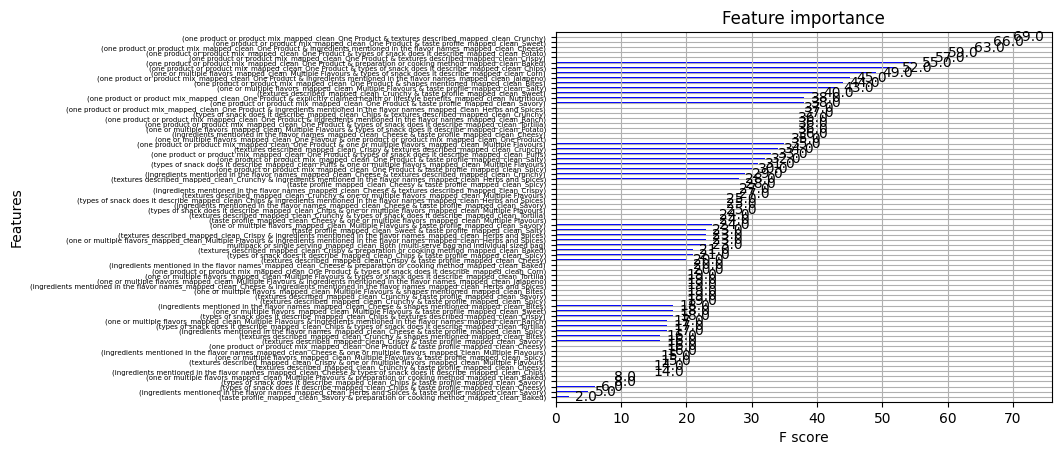

In [16]:
plt.figure(figsize=(16, 20))

# Change the colors of the plot
color = 'blue'  # You can change this to any color you prefer
important_features = xgb.plot_importance(model, importance_type='weight', color=color)

plt.yticks(fontsize=5)

plt.show()


### Adjusting Feature Weights Based On Importance Scores:

In [17]:
# Adjust feature weights based on importance scores
for feature_name, importance_score in importance_scores.items():
    # Calculate the weight based on the importance score
    weight = 1.0 / importance_score
    # Modify the feature weight in the model
    model.get_booster().get_score(importance_type='weight')[feature_name] = weight

### Retraining The Data

In [18]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Actual vs. Predicted Plot

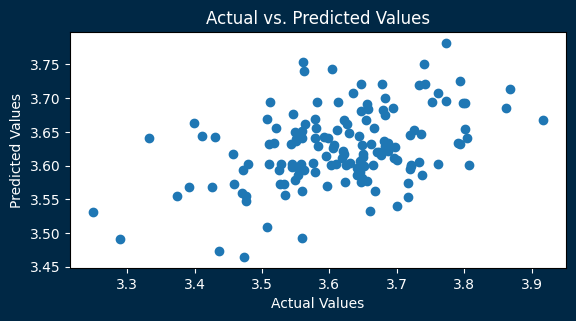

In [19]:
# Assuming y_test and y_pred are your actual and predicted values
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values", color='white')
plt.ylabel("Predicted Values", color='white')
plt.title("Actual vs. Predicted Values", color='white')

# Set the same scale for both axes
plt.gca().set_aspect('equal', adjustable='box')

# Set the background color
plt.gcf().set_facecolor('#002845') 

# Set tick colors to white
plt.gca().tick_params(axis='x', colors='white')  # X-axis tick color
plt.gca().tick_params(axis='y', colors='white')  # Y-axis tick color

plt.show()

## Residual Plot

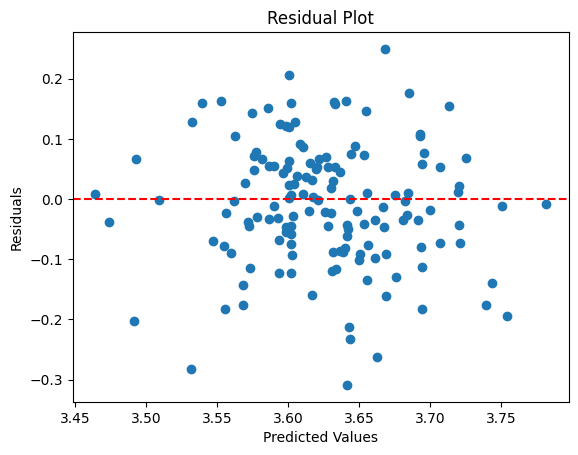

In [32]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color='red', linestyle='--')  # Add a horizontal line at y=0
plt.show()

## Metrics

In [37]:
# Calculate R2 score for the training set
y_train_pred = model.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)

# Calculate R2 score for the testing set
y_test_pred = model.predict(X_test) 
r2_test = r2_score(y_test, y_test_pred)

print("R2 score for the training set:", r2_train)
print("R2 score for the testing set:", r2_test)

R2 score for the training set: 0.5274754460836757
R2 score for the testing set: 0.16800432887956618


In [35]:
print("MAE Score of training set: ", mean_absolute_error(y_train, y_train_pred))
print("MAE Score of testing set: ", mean_absolute_error(y_test, y_pred))

MAE Score of training set:  0.06257065701719916
MAE Score of testing set:  0.08166325029126008


In [36]:
print("RMSE Score of training set: ", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("RMSE Score of testing set: ", np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE Score of training set:  0.08135711707088188
RMSE Score of testing set:  0.10360390513996774


## Export As Python File

In [24]:
import nbformat

notebook_file = 'xgboost.ipynb'

# Read the notebook file.
with open(notebook_file, 'r', encoding='utf-8') as notebook_file:
    notebook_content = nbformat.read(notebook_file, as_version=4)

# Initialize an empty string to store the concatenated code.
concatenated_code = ''

# Iterate through the notebook cells and append code cells to the concatenated_code.
for cell in notebook_content.cells:
    if cell.cell_type == 'code':
        concatenated_code += cell.source + '\n\n'

# Write the concatenated code to a Python script file.
with open('xgboost_exported.py', 'w', encoding='utf-8') as script_file:
    script_file.write(concatenated_code)

<Figure size 2000x1000 with 0 Axes>

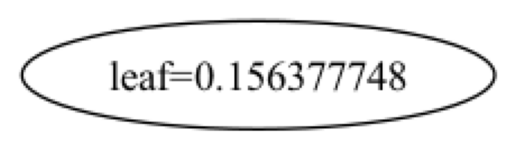

In [25]:


# Set a larger figure size to display the entire tree
plt.figure(figsize=(20, 10))

# Plot the entire tree
plot_tree(model)

# Save the plot to an image file (optional)
plt.savefig('xgboost_tree.png')

# Show the plot
plt.show()